# Classification Model using Descriptor Variables

This notebook aims to build a classification model using the Flipkart descriptor variables.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, LabelEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score

In [3]:
# Change to your own directory
try:
    os.chdir("/content/drive/MyDrive/BT4211 Data-driven Marketing")
    print("Directory changed")
except OSError:
    print("Error: Can't change the Current Working Directory")

Directory changed


In [4]:
# Load datasets
psycho_demo_num_df = pd.read_csv('Data/psycho_demo_num.csv')
target_df = pd.read_csv('Data/RFM_4_segment.csv', usecols=['Name', 'Cluster'])
factor_df = pd.read_csv('Data/factor_features.csv')

In [5]:
# Seperate psychographic and demographic df
psycho_demo_num_cols = psycho_demo_num_df.columns.tolist()
demo_num_cols = ['Name', 'Gender', 'Marital Status', 'Income (per month)', 'Age', 'Has Child', 'Lives in City Tier', 'Employed']
psycho_num_cols = ['Name'] + [col for col in psycho_demo_num_cols if col not in demo_num_cols]

demo_num_df = psycho_demo_num_df[demo_num_cols]
psycho_num_df = psycho_demo_num_df[psycho_num_cols]

In [6]:
psycho_demo_num_df.head()

,Name,Gender,Marital Status,Income (per month),Hobbies Count,"In most ways, my life is close to my ideal",The conditions in my life are excellent,"So far, I have got the important things I want in my life","If I could live my life over, I would change almost nothing",Many people have directly or indirectly contributed to my progress in life,...,Exercise Frequency,Preferred Mode of Payment_Cash On Delivery,Preferred Mode of Payment_Credit Card,Preferred Mode of Payment_Debit Card,Preferred Mode of Payment_Net Banking,Preferred Mode of Payment_Online Wallets,Preferred Mode of Payment_UPI,Volunteer Frequency,Hobbies Frequency,Care for Chronic Illness
0,G6M1R6,1,0,0,2,5,4,4,4,5,...,0,0,0,0,0,0,1,4,2,0
1,G6M1R1,1,0,2,4,2,2,3,1,4,...,1,0,0,0,0,0,1,1,2,0
2,G6M1R8,0,1,3,2,6,6,5,6,7,...,1,0,0,0,0,0,1,4,3,0
3,G6M1R5,1,0,0,2,5,5,4,6,7,...,3,0,0,1,0,0,0,2,2,0
4,G6M1R9,1,0,0,1,6,5,6,1,4,...,0,0,0,1,0,0,0,2,2,0


In [7]:
target_df.head()

,Name,Cluster
0,G1M1R1,Lost Customer
1,G1M1R2,Low Value Customer
2,G1M1R3,Low Value Customer
3,G1M1R4,Low Value Customer
4,G1M1R5,Low Value Customer


In [8]:
target_df['Cluster'].value_counts()

Low Value Customer       98
Medium Value Customer    80
High Value Customer      61
Lost Customer            54
Name: Cluster, dtype: int64

In [9]:
factor_df.head()

,Name,factor_0,factor_1,factor_2,factor_3,factor_4,factor_5,factor_6,factor_7,factor_8,factor_9,factor_10,factor_11,factor_12,factor_13,factor_14,factor_15,factor_16,factor_17
0,G6M1R6,15.490973,14.357445,19.584959,13.679971,12.883040,11.227560,5.652055,0.0,7.674898,0.758341,0.000000,4.948202,0.000000,3.492176,0.0,1.711722,1.054131,0.0
1,G6M1R1,23.105981,14.920707,20.400999,6.910766,12.263658,12.049639,6.153206,0.0,8.667854,0.758341,1.454190,7.422302,0.000000,3.427362,0.0,2.567583,2.017389,0.0
2,G6M1R8,24.379846,22.381797,25.384124,18.455219,17.089557,14.737336,7.494564,0.0,11.766890,0.758341,1.454190,7.408195,0.000000,5.642379,0.0,2.567583,2.499018,0.0
3,G6M1R5,11.415572,17.989765,19.584959,15.853497,16.212940,17.015703,1.413014,0.0,10.552997,0.000000,2.922577,5.573781,0.956597,3.961105,0.0,1.711722,0.527066,0.0
4,G6M1R9,18.605517,25.118520,18.768919,13.406280,18.915096,17.972985,4.849414,0.0,6.477784,0.000000,0.000000,3.725259,0.956597,4.834149,0.0,0.855861,0.527066,0.0


# Classification Models

## Define functions

In [10]:
# Define dataframe to store all results
results_df = pd.DataFrame(columns=["Model", "Transformation", "Test Accuracy", "Test Balanced Accuracy", "Val Accuracy", "Val Balanced Accuracy"])

In [12]:
def update_results_df(model, transformation, val_acc, val_bal_acc, test_acc, test_bal_acc):
  """Update results dataframe."""

  global results_df

  results_dict = {'Model': model, 'Transformation': transformation, 'Val Accuracy': val_acc, 'Val Balanced Accuracy': val_bal_acc, 'Test Accuracy': test_acc, 'Test Balanced Accuracy': test_bal_acc}
  results_df = results_df.append(results_dict, ignore_index=True)

In [13]:
def get_train_test_data(df, test_size=0.2, seed=123):
  """Get train test data merging df input with target dataframe."""

  global target_df

  # Combine datasets
  df = df.merge(target_df, on='Name')

  # Separate target variable
  y = df['Cluster']
  X = df.drop(['Name', 'Cluster'], axis=1)

  # Train test data split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

  # Prepare target
  le = LabelEncoder()
  le.fit(y_train)
  mapping = le.classes_
  y_train_enc = le.transform(y_train)
  y_test_enc = le.transform(y_test)

  return X_train, X_test, y_train_enc, y_test_enc, mapping

In [14]:
def scale_data(X_train, X_test, scaler):
  """Scale data with log, minmax or boxcox scaler (only for 'Age' column without 0 values)."""

  assert scaler in [None, 'log', 'minmax', 'box-cox'], "Scaler not accepted"

  X_train_norm = X_train.copy()
  X_test_norm = X_test.copy()

  if scaler == None:
    pass

  elif scaler == 'log':
    X_train_norm['Age'] = np.log(X_train_norm[['Age']])
    X_test_norm['Age'] = np.log(X_test_norm[['Age']].fillna(np.mean))

  else:
    if scaler == 'minmax':
      norm = MinMaxScaler()
    elif scaler == 'box-cox':
      norm = PowerTransformer(method='box-cox')

    # Fit scaler on train data
    norm = norm.fit(X_train_norm[['Age']])

    # Transform train data
    X_train_norm['Age'] = norm.transform(X_train_norm[['Age']])

    # Transform test data
    X_test_norm['Age'] = norm.transform(X_test_norm[['Age']])

  return X_train_norm, X_test_norm

In [15]:
def run_model(X_train_norm, X_test_norm, y_train, gridsearch=True, cv=5):
  """Run model and perform gridsearch."""

  # Define parameters for GridSearchCV
  params = {'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
            'C': np.logspace(-3,3,7)}

  # Define the multinomial logistic regression model
  model = LogisticRegression(multi_class='multinomial', max_iter=10000, n_jobs=-1)

  if gridsearch:
    model = GridSearchCV(model, params, scoring='accuracy', n_jobs=-1, cv=cv, verbose=1)

  model.fit(X_train_norm, y_train)

  # Get model predictions
  y_pred = model.predict(X_test_norm)

  return model, y_pred

In [16]:
def plot_confusion_matrix(mapping, y_test, y_pred):
  """Plot confusion matrix."""

  # Plot confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred)

  ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

  ax.set_title('Confusion Matrix')
  ax.set_xlabel('Predicted Values')
  ax.set_ylabel('Actual Values')

  # Ticket labels
  ax.xaxis.set_ticklabels(mapping, rotation=90)
  ax.yaxis.set_ticklabels(mapping, rotation=0)

  # Display the visualization of the Confusion Matrix.
  plt.show()

In [17]:
def model_evaluation(model, X_train, y_train, y_test, y_pred, mapping, cv=5):
  """Evaluate val and test model performance."""

  # Get and print scores
  val_acc = np.mean(cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy'))
  val_bal_acc = np.mean(cross_val_score(model, X_train, y_train, cv=cv, scoring='balanced_accuracy'))
  test_acc = accuracy_score(y_test, y_pred)
  test_bal_acc = balanced_accuracy_score(y_test, y_pred)

  print('Val Accuracy: {:.4f}'.format(val_acc))
  print('Val Balanced Accuracy: {:.4f}'.format(val_bal_acc))
  print('Test Accuracy: {:.4f}'.format(test_acc))
  print('Test Balanced Accuracy: {:.4f}'.format(test_bal_acc))

  # Print classification report
  print("Test Classification Report:")
  print(classification_report(y_test, y_pred, digits=4, target_names=mapping, zero_division=0))

  return val_acc, val_bal_acc, test_acc, test_bal_acc

In [18]:
def get_gridsearch_feature_importance(model):
  """Get feature importance from GridSearchCV."""

  # Get importance
  odds = np.exp(model.best_estimator_.coef_[0])
  importance = pd.DataFrame(odds, X_train_norm.columns, columns=['coef']).sort_values(by='coef', ascending=False)

  return importance

## Demographic Model

### No Scaling

In [19]:
# Split data into x and y variables
X_train, X_test, y_train, y_test, mapping = get_train_test_data(demo_num_df)

In [20]:
# Scale train and test data
X_train_norm, X_test_norm = scale_data(X_train, X_test, None)

In [21]:
# Run model
model, y_pred = run_model(X_train_norm, X_test_norm, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


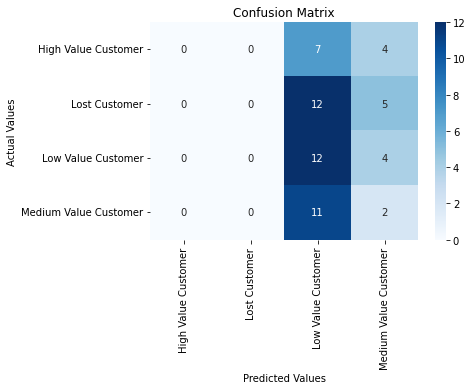

In [22]:
# Plot confusion matrix
plot_confusion_matrix(mapping, y_test, y_pred)

In [23]:
# Evaluate model
val_acc, val_bal_acc, test_acc, test_bal_acc = model_evaluation(model, X_train_norm, y_train, y_test, y_pred, mapping)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Val Accuracy: 0.3157
Val Balanced Accuracy: 0.2334
Test Accuracy: 0.2456
Test Balanced Accuracy: 0.2260
Test Classification Report:
                       precision    recall  f1-score   support

  High Value Customer     0.0000    0.0000    0.0000        11
        Lost Customer     0.0000    0.0000    0.0000        17
   Low Value Customer     0.2857    0.7500    0.4138      

In [24]:
# Get GridSearchCV feature importance
feature_importance = get_gridsearch_feature_importance(model)
feature_importance

,coef
Lives in City Tier,1.075632
Income (per month),1.059649
Age,1.028311
Gender,1.017750
Employed,0.940388
Marital Status,0.923131
Has Child,0.889745


In [25]:
# Append to results_df
update_results_df('Demographic', 'No Scaling', val_acc, val_bal_acc, test_acc, test_bal_acc)

### MinMaxScaler

In [26]:
# Split data into x and y variables
X_train, X_test, y_train, y_test, mapping = get_train_test_data(demo_num_df)

In [27]:
# Scale train and test data
X_train_norm, X_test_norm = scale_data(X_train, X_test, 'minmax')

In [ ]:
# Run model
model, y_pred = run_model(X_train_norm, X_test_norm, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


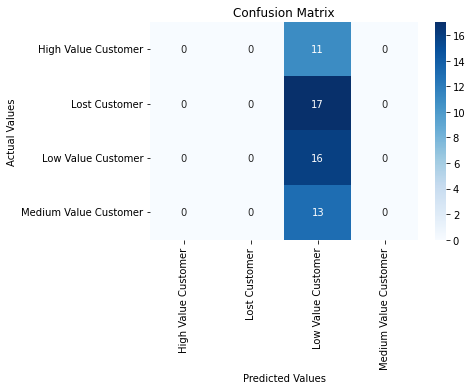

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(mapping, y_test, y_pred)

In [ ]:
# Evaluate model
val_acc, val_bal_acc, test_acc, test_bal_acc = model_evaluation(model, X_train_norm, y_train, y_test, y_pred, mapping)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Val Accuracy: 0.3334
Val Balanced Accuracy: 0.2418
Test Accuracy: 0.2807
Test Balanced Accuracy: 0.2500
Test Classification Report:
                       precision    recall  f1-score   support

  High Value Customer     0.0000    0.0000    0.0000        11
        Lost Customer     0.0000    0.0000    0.0000        17
   Low Value Customer     0.2807    1.0000    0.4384      

In [ ]:
# Get GridSearchCV feature importance
feature_importance = get_gridsearch_feature_importance(model)
feature_importance

,coef
Income (per month),1.012230
Lives in City Tier,1.002721
Employed,1.001758
Age,1.001247
Marital Status,1.000828
Gender,1.000414
Has Child,1.000301


In [ ]:
# Append to results_df
update_results_df('Demographic', 'Min Max', val_acc, val_bal_acc, test_acc, test_bal_acc)

### Log Transformation

In [ ]:
# Split data into x and y variables
X_train, X_test, y_train, y_test, mapping = get_train_test_data(demo_num_df)

In [ ]:
# Scale train and test data
X_train_norm, X_test_norm = scale_data(X_train, X_test, 'log')

In [ ]:
# Run model
model, y_pred = run_model(X_train_norm, X_test_norm, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


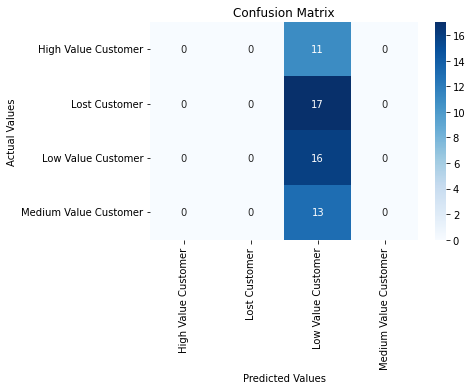

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(mapping, y_test, y_pred)

In [ ]:
# Evaluate model
val_acc, val_bal_acc, test_acc, test_bal_acc = model_evaluation(model, X_train_norm, y_train, y_test, y_pred, mapping)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Val Accuracy: 0.3334
Val Balanced Accuracy: 0.2418
Test Accuracy: 0.2807
Test Balanced Accuracy: 0.2500
Test Classification Report:
                       precision    recall  f1-score   support

  High Value Customer     0.0000    0.0000    0.0000        11
        Lost Customer     0.0000    0.0000    0.0000        17
   Low Value Customer     0.2807    1.0000    0.4384      

In [ ]:
# Get GridSearchCV feature importance
feature_importance = get_gridsearch_feature_importance(model)
feature_importance

,coef
Income (per month),1.012221
Lives in City Tier,1.002722
Age,1.002287
Employed,1.001754
Marital Status,1.000824
Gender,1.000414
Has Child,1.000297


In [ ]:
# Append to results_df
update_results_df('Demographic', 'Log', val_acc, val_bal_acc, test_acc, test_bal_acc)

### Box-Cox Transformation

In [ ]:
# Split data into x and y variables
X_train, X_test, y_train, y_test, mapping = get_train_test_data(demo_num_df)

In [ ]:
# Scale train and test data
X_train_norm, X_test_norm = scale_data(X_train, X_test, 'box-cox')

In [ ]:
# Run model
model, y_pred = run_model(X_train_norm, X_test_norm, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


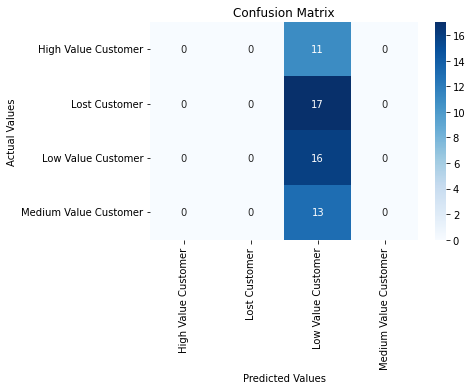

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(mapping, y_test, y_pred)

In [ ]:
# Evaluate model
val_acc, val_bal_acc, test_acc, test_bal_acc = model_evaluation(model, X_train_norm, y_train, y_test, y_pred, mapping)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Val Accuracy: 0.3379
Val Balanced Accuracy: 0.2457
Test Accuracy: 0.2807
Test Balanced Accuracy: 0.2500
Test Classification Report:
                       precision    recall  f1-score   support

  High Value Customer     0.0000    0.0000    0.0000        11
        Lost Customer     0.0000    0.0000    0.0000        17
   Low Value Customer     0.2807    1.0000    0.4384      

In [ ]:
# Get GridSearchCV feature importance
feature_importance = get_gridsearch_feature_importance(model)
feature_importance

,coef
Income (per month),1.011958
Age,1.011196
Lives in City Tier,1.002763
Employed,1.001618
Marital Status,1.000700
Gender,1.000408
Has Child,1.000189


In [ ]:
# Append to results_df
update_results_df('Demographic', 'Box-Cox', val_acc, val_bal_acc, test_acc, test_bal_acc)

## Psychometric Model

### No Scaling

In [ ]:
# Split data into x and y variables
X_train, X_test, y_train, y_test, mapping = get_train_test_data(psycho_num_df)

In [ ]:
# Scale train and test data
X_train_norm, X_test_norm = scale_data(X_train, X_test, None)

In [ ]:
# Run model
model, y_pred = run_model(X_train_norm, X_test_norm, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


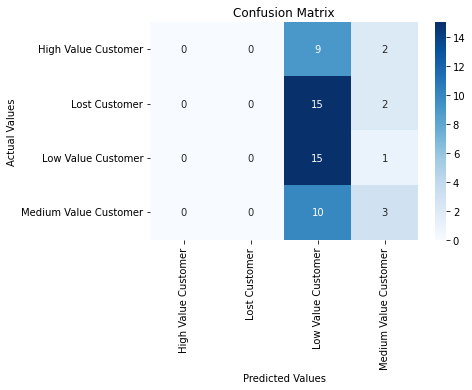

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(mapping, y_test, y_pred)

In [ ]:
# Evaluate model
val_acc, val_bal_acc, test_acc, test_bal_acc = model_evaluation(model, X_train_norm, y_train, y_test, y_pred, mapping)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Val Accuracy: 0.3332
Val Balanced Accuracy: 0.2401
Test Accuracy: 0.3158
Test Balanced Accuracy: 0.2921
Test Classification Report:
                       precision    recall  f1-score   support

  High Value Customer     0.0000    0.0000    0.0000        11
        Lost Customer     0.0000    0.0000    0.0000        17
   Low Value Customer     0.3061    0.9375    0.4615      

In [ ]:
# Get GridSearchCV feature importance
feature_importance = get_gridsearch_feature_importance(model)
feature_importance

,coef
"If I could live my life over, I would change almost nothing",1.015701
People should keep their troubles to themselves,1.012476
Traditional values are important for me,1.012172
"When making a decision, I take other people's needs and feelings into account.",1.010766
I like to get quick results,1.010208
I am willing to give up today’s fun for future success,1.009726
I have all the things I really need to enjoy life,1.008587
It upsets me when my work is not recognized by others,1.008584
The things I own say a lot about how well I’m doing in life,1.007390
Hobbies Frequency,1.006550


In [ ]:
# Append to results_df
update_results_df('Psychometric', 'No Scaling', val_acc, val_bal_acc, test_acc, test_bal_acc)

## Psychometric Demographic Model

### No Scaling

In [ ]:
# Split data into x and y variables
X_train, X_test, y_train, y_test, mapping = get_train_test_data(psycho_demo_num_df)

In [ ]:
# Scale train and test data
X_train_norm, X_test_norm = scale_data(X_train, X_test, None)

In [ ]:
# Run model
model, y_pred = run_model(X_train_norm, X_test_norm, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


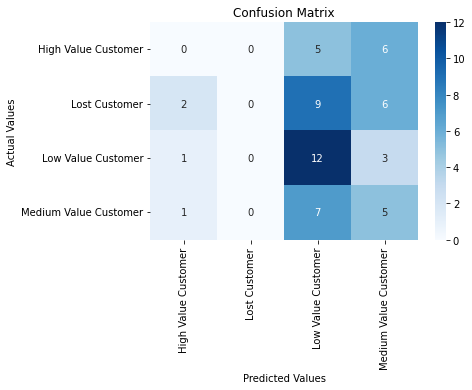

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(mapping, y_test, y_pred)

In [ ]:
# Evaluate model
val_acc, val_bal_acc, test_acc, test_bal_acc = model_evaluation(model, X_train_norm, y_train, y_test, y_pred, mapping)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Val Accuracy: 0.3381
Val Balanced Accuracy: 0.2786
Test Accuracy: 0.2982
Test Balanced Accuracy: 0.2837
Test Classification Report:
                       precision    recall  f1-score   support

  High Value Customer     0.0000    0.0000    0.0000        11
        Lost Customer     0.0000    0.0000    0.0000        17
   Low Value Customer     0.3636    0.7500    0.4898      

In [ ]:
# Get GridSearchCV feature importance
feature_importance = get_gridsearch_feature_importance(model)
feature_importance

,coef
"If I could live my life over, I would change almost nothing",1.077910
People should keep their troubles to themselves,1.063285
I am willing to give up today’s fun for future success,1.063114
"When making a decision, I take other people's needs and feelings into account.",1.062373
Traditional values are important for me,1.061749
...,...
My happiness does not depend on things I own,0.948396
I walk/cycle/use public transport to save fuel,0.943465
"I admire people who own expensive homes, cars, and clothes",0.936525
Exercise Frequency,0.935385


In [ ]:
# Append to results_df
update_results_df('Psychometric Demographic', 'No Scaling', val_acc, val_bal_acc, test_acc, test_bal_acc)

### MinMaxScaler

In [ ]:
# Split data into x and y variables
X_train, X_test, y_train, y_test, mapping = get_train_test_data(psycho_demo_num_df)

In [ ]:
# Scale train and test data
X_train_norm, X_test_norm = scale_data(X_train, X_test, 'minmax')

In [ ]:
# Run model
model, y_pred = run_model(X_train_norm, X_test_norm, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


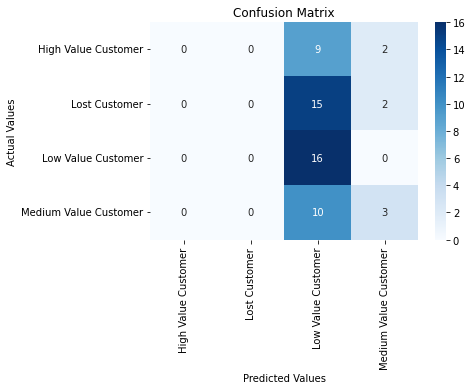

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(mapping, y_test, y_pred)

In [ ]:
# Evaluate model
val_acc, val_bal_acc, test_acc, test_bal_acc = model_evaluation(model, X_train_norm, y_train, y_test, y_pred, mapping)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Val Accuracy: 0.3332
Val Balanced Accuracy: 0.2363
Test Accuracy: 0.3333
Test Balanced Accuracy: 0.3077
Test Classification Report:
                       precision    recall  f1-score   support

  High Value Customer     0.0000    0.0000    0.0000        11
        Lost Customer     0.0000    0.0000    0.0000        17
   Low Value Customer     0.3200    1.0000    0.4848      

In [ ]:
# Get GridSearchCV feature importance
feature_importance = get_gridsearch_feature_importance(model)
feature_importance

,coef
"If I could live my life over, I would change almost nothing",1.015757
People should keep their troubles to themselves,1.012877
Income (per month),1.012369
Traditional values are important for me,1.012212
"When making a decision, I take other people's needs and feelings into account.",1.011019
...,...
My happiness does not depend on things I own,0.989263
Meditation Frequency,0.988904
"I admire people who own expensive homes, cars, and clothes",0.988324
I sign petitions related to environmental issues,0.987378


In [ ]:
# Append to results_df
update_results_df('Psychometric Demographic', 'Min Max', val_acc, val_bal_acc, test_acc, test_bal_acc)

### Log Transformation

In [ ]:
# Split data into x and y variables
X_train, X_test, y_train, y_test, mapping = get_train_test_data(psycho_demo_num_df)

In [ ]:
# Scale train and test data
X_train_norm, X_test_norm = scale_data(X_train, X_test, 'log')

In [ ]:
# Run model
model, y_pred = run_model(X_train_norm, X_test_norm, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


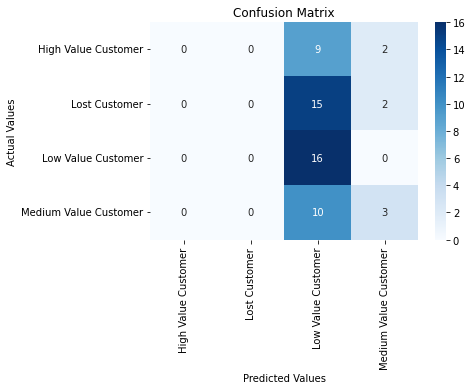

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(mapping, y_test, y_pred)

In [ ]:
# Evaluate model
val_acc, val_bal_acc, test_acc, test_bal_acc = model_evaluation(model, X_train_norm, y_train, y_test, y_pred, mapping)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Val Accuracy: 0.3289
Val Balanced Accuracy: 0.2401
Test Accuracy: 0.3333
Test Balanced Accuracy: 0.3077
Test Classification Report:
                       precision    recall  f1-score   support

  High Value Customer     0.0000    0.0000    0.0000        11
        Lost Customer     0.0000    0.0000    0.0000        17
   Low Value Customer     0.3200    1.0000    0.4848      

In [ ]:
# Get GridSearchCV feature importance
feature_importance = get_gridsearch_feature_importance(model)
feature_importance

,coef
"If I could live my life over, I would change almost nothing",1.015752
People should keep their troubles to themselves,1.012878
Income (per month),1.012361
Traditional values are important for me,1.012211
"When making a decision, I take other people's needs and feelings into account.",1.011018
...,...
My happiness does not depend on things I own,0.989262
Meditation Frequency,0.988902
"I admire people who own expensive homes, cars, and clothes",0.988322
I sign petitions related to environmental issues,0.987382


In [ ]:
# Append to results_df
update_results_df('Psychometric Demographic', 'Log', val_acc, val_bal_acc, test_acc, test_bal_acc)

### Box-Cox Transformation

In [ ]:
# Split data into x and y variables
X_train, X_test, y_train, y_test, mapping = get_train_test_data(psycho_demo_num_df)

In [ ]:
# Scale train and test data
X_train_norm, X_test_norm = scale_data(X_train, X_test, 'box-cox')

In [ ]:
# Run model
model, y_pred = run_model(X_train_norm, X_test_norm, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


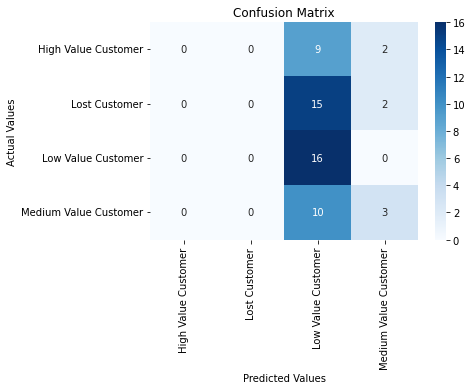

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(mapping, y_test, y_pred)

In [ ]:
# Evaluate model
val_acc, val_bal_acc, test_acc, test_bal_acc = model_evaluation(model, X_train_norm, y_train, y_test, y_pred, mapping)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Val Accuracy: 0.3158
Val Balanced Accuracy: 0.2424
Test Accuracy: 0.3333
Test Balanced Accuracy: 0.3077
Test Classification Report:
                       precision    recall  f1-score   support

  High Value Customer     0.0000    0.0000    0.0000        11
        Lost Customer     0.0000    0.0000    0.0000        17
   Low Value Customer     0.3200    1.0000    0.4848      

In [ ]:
# Get GridSearchCV feature importance
feature_importance = get_gridsearch_feature_importance(model)
feature_importance

,coef
"If I could live my life over, I would change almost nothing",1.015585
People should keep their troubles to themselves,1.012901
Traditional values are important for me,1.012174
Income (per month),1.012120
"When making a decision, I take other people's needs and feelings into account.",1.010948
...,...
My happiness does not depend on things I own,0.989224
Meditation Frequency,0.988853
"I admire people who own expensive homes, cars, and clothes",0.988294
I sign petitions related to environmental issues,0.987482


In [ ]:
# Append to results_df
update_results_df('Psychometric Demographic', 'Box-Cox', val_acc, val_bal_acc, test_acc, test_bal_acc)

## Factorised Model

### No Scaling

In [ ]:
# Split data into x and y variables
X_train, X_test, y_train, y_test, mapping = get_train_test_data(factor_df)

In [ ]:
# Scale train and test data
X_train_norm, X_test_norm = scale_data(X_train, X_test, None)

In [ ]:
# Run model
model, y_pred = run_model(X_train_norm, X_test_norm, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


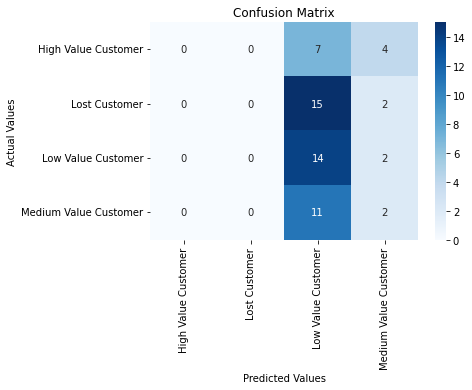

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(mapping, y_test, y_pred)

In [ ]:
# Evaluate model
val_acc, val_bal_acc, test_acc, test_bal_acc = model_evaluation(model, X_train_norm, y_train, y_test, y_pred, mapping)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Val Accuracy: 0.3505
Val Balanced Accuracy: 0.2620
Test Accuracy: 0.2807
Test Balanced Accuracy: 0.2572
Test Classification Report:
                       precision    recall  f1-score   support

  High Value Customer     0.0000    0.0000    0.0000        11
        Lost Customer     0.0000    0.0000    0.0000        17
   Low Value Customer     0.2979    0.8750    0.4444      

In [ ]:
# Get GridSearchCV feature importance
feature_importance = get_gridsearch_feature_importance(model)
feature_importance

,coef
factor_3,1.012157
factor_7,1.011024
factor_2,1.010018
factor_9,1.007293
factor_6,1.004484
factor_8,1.003989
factor_5,1.003135
factor_13,0.998436
factor_10,0.997146
factor_11,0.996351


In [ ]:
# Append to results_df
update_results_df('Factorised', 'No Scaling', val_acc, val_bal_acc, test_acc, test_bal_acc)

# Performance Analysis

In [ ]:
# # Save results to CSV
# results_df.to_csv('Data/classification_results.csv', index=False)

In [ ]:
# # Load results df
# results_df = pd.read_csv('Data/classification_results.csv')

In [ ]:
results_df

,Model,Transformation,Test Accuracy,Test Balanced Accuracy,Val Accuracy,Val Balanced Accuracy
0,Demographic,No Scaling,0.245614,0.225962,0.315652,0.233379
1,Demographic,Min Max,0.280702,0.250000,0.333430,0.241827
2,Demographic,Log,0.280702,0.250000,0.333430,0.241827
3,Demographic,Box-Cox,0.280702,0.250000,0.337874,0.245673
4,Psychometric,No Scaling,0.315789,0.292067,0.333237,0.240110
5,Psychometric Demographic,No Scaling,0.298246,0.283654,0.338068,0.278552
6,Psychometric Demographic,Min Max,0.333333,0.307692,0.333237,0.236264
7,Psychometric Demographic,Log,0.333333,0.307692,0.328889,0.240110
8,Psychometric Demographic,Box-Cox,0.333333,0.307692,0.315845,0.242422
9,Factorised,No Scaling,0.280702,0.257212,0.350531,0.261951
